### packages

In [1]:
import sys
import os
os.getcwd()

'c:\\Users\\ebaca\\Desktop\\CMD Research\\CMD Remote Repository\\autoencoder practice'

In [2]:
'''importing packages & necessary functions'''

# pytorch functionalities
import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F

# data processing
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split

# plotting & visualization
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid

# others
import tqdm
import numpy as np
import webp
from IPython.display import clear_output

sys.path.append('..')
from functions import net

# gpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### notes

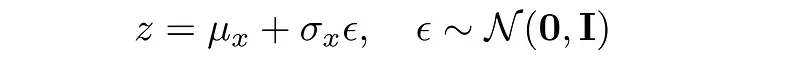

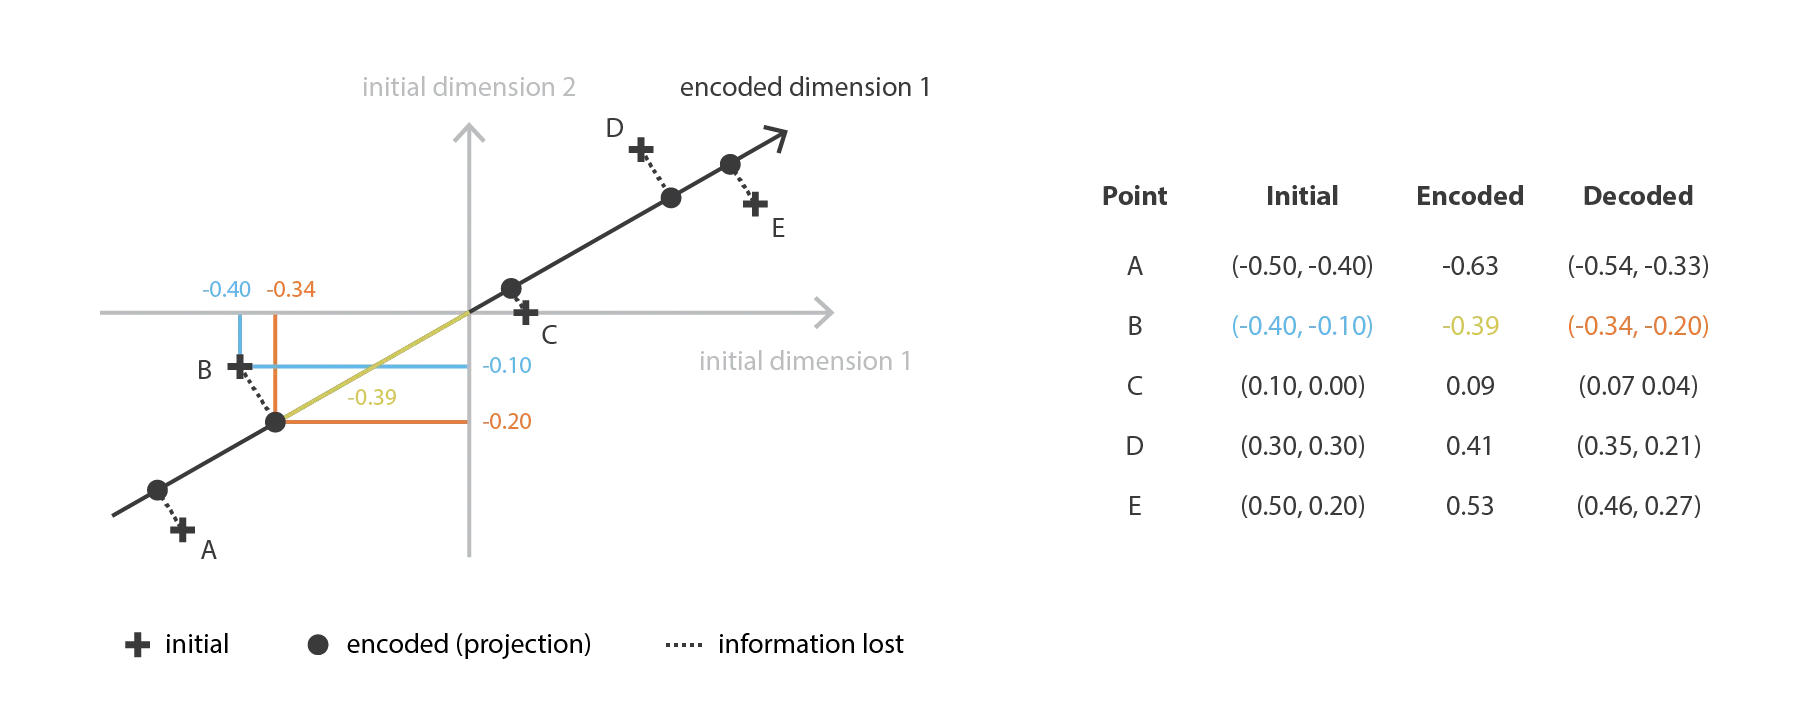

In [3]:
display(webp.load_image('../images/vae latent vector formula.webp'), 
        webp.load_image('../images/latent space visual.webp'))

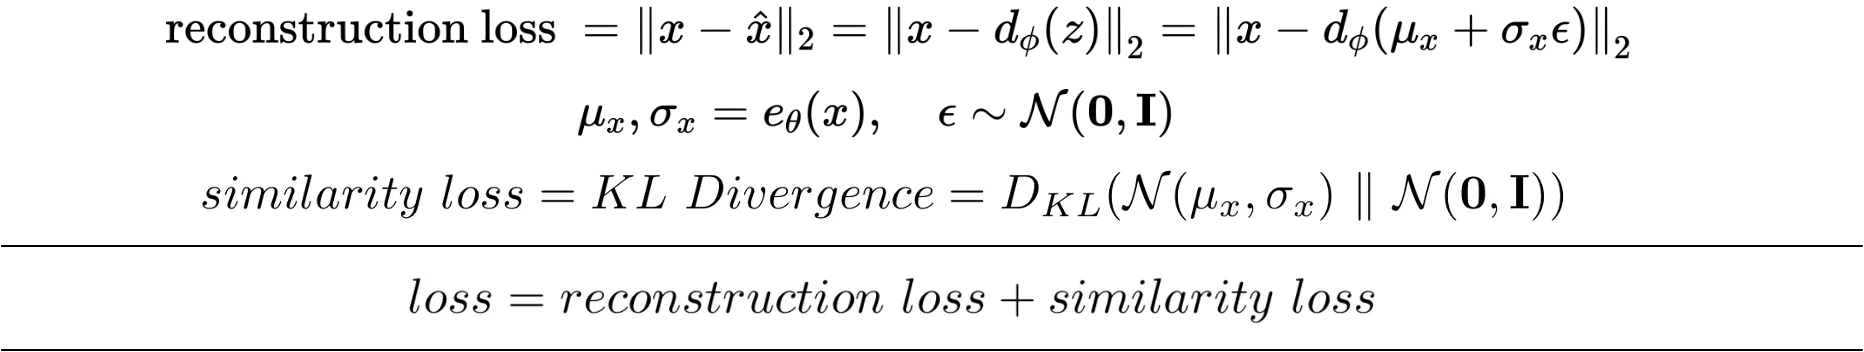

In [4]:
display(webp.load_image('../images/loss explained.webp'))

### gather data

In [5]:
# create a transofrm to apply to each datapoint
transform = transforms.Compose([transforms.ToTensor()])

# download the MNIST datasets
path = '../../Local Data Files/MNIST'
train_dataset = MNIST(path, transform=transform, download=True)
test_dataset  = MNIST(path, transform=transform, download=True)
# using the same data as testing since we are trying to reproduce the images
print(type(train_dataset))

# 80-20 train-val split
n_train = int(0.8*len(train_dataset))
n_val = len(train_dataset) - n_train
train_dataset, val_dataset = random_split(train_dataset, [n_train, n_val], generator=np.random.seed(0))
print(f"Train dataset size: {len(train_dataset)}, Validation dataset size: {len(val_dataset)}, Test dataset size: {len(test_dataset)}")
print(f"Image size: {train_dataset[0][0].size()}")

# create train, validation and test dataloaders
batch_size = 100
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

<class 'torchvision.datasets.mnist.MNIST'>
Train dataset size: 48000, Validation dataset size: 12000, Test dataset size: 60000
Image size: torch.Size([1, 28, 28])


### building architecture

In [6]:
# building the encoder class
class encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, latent_dim, leak=0.2, drop=0.5):
        super(encoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LeakyReLU(leak), nn.Dropout(drop),

            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(), nn.Dropout(drop),

            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(), nn.Dropout(drop),

            nn.Linear(hidden_dim, num_layers),
            nn.LeakyReLU(leak), nn.Dropout(drop)
        )
        
        # Latent mean and variance
        self.latent_mean = nn.Linear(num_layers, latent_dim)
        self.latent_variance = nn.Linear(num_layers, latent_dim)

    def forward(self, x):
        x = self.encoder(x)
        mean, variance = self.latent_mean(x), self.latent_variance(x)
        return mean, variance

# building the decoder class
class decoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, latent_dim, leak=0.2, drop=0.5):
        super(decoder, self).__init__()

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, num_layers),
            
            nn.Dropout(drop), nn.LeakyReLU(leak),
            nn.Linear(num_layers, hidden_dim),

            nn.Dropout(drop), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),

            nn.Dropout(drop), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            
            nn.Dropout(drop), nn.LeakyReLU(leak),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Linear(hidden_dim, input_dim),

            nn.Sigmoid()
        )

    def forward(self, x):
        return self.decoder(x)

# VAE class with stochastic/deterministic toggle
class vae(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, latent_dim, leak=0.2, drop=0.5, stochastic=True):
        super(vae, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.latent_dim = latent_dim
        self.leak = leak
        self.drop = drop
        self.stochastic = stochastic

        self.encoder = encoder(
            input_dim=input_dim, 
            hidden_dim=hidden_dim, 
            num_layers=num_layers, 
            latent_dim=latent_dim,
            leak=leak, 
            drop=drop
        ).to(device)

        self.decoder = decoder(
            input_dim=input_dim, 
            hidden_dim=hidden_dim, 
            num_layers=num_layers, 
            latent_dim=latent_dim,
            leak=leak, 
            drop=drop
        ).to(device)
    
    # Sample z based on its latent space distribution
    def reparameterize(self, mean, variance):
        if self.stochastic:
            stdev = torch.randn_like(variance).to(device)
            return mean + variance * stdev
        else:
            return mean  # Deterministic case

    def forward(self, x):
        x = x.to(device)
        mean, variance = self.encoder(x)
        z_sample = self.reparameterize(mean, variance)
        z = self.decoder(z_sample)  # Reconstruct the original input
        return z, mean, variance

### initialize & train

In [7]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    # loss = reconstruction loss + similarity loss (KL divergence)
    return reproduction_loss + KLD

In [8]:
print(f"Train dataset size: {len(train_dataset)}, Validation dataset size: {len(val_dataset)}, Test dataset size: {len(test_dataset)}")
print(f"Image size: {train_dataset[0][0].size()}")

# compressed image size: 28x28 = 784
img_size = train_dataset[0][0].size()[1]*train_dataset[0][0].size()[2] 
print(f"Compressed Image Size: {img_size}")

Train dataset size: 48000, Validation dataset size: 12000, Test dataset size: 60000
Image size: torch.Size([1, 28, 28])
Compressed Image Size: 784


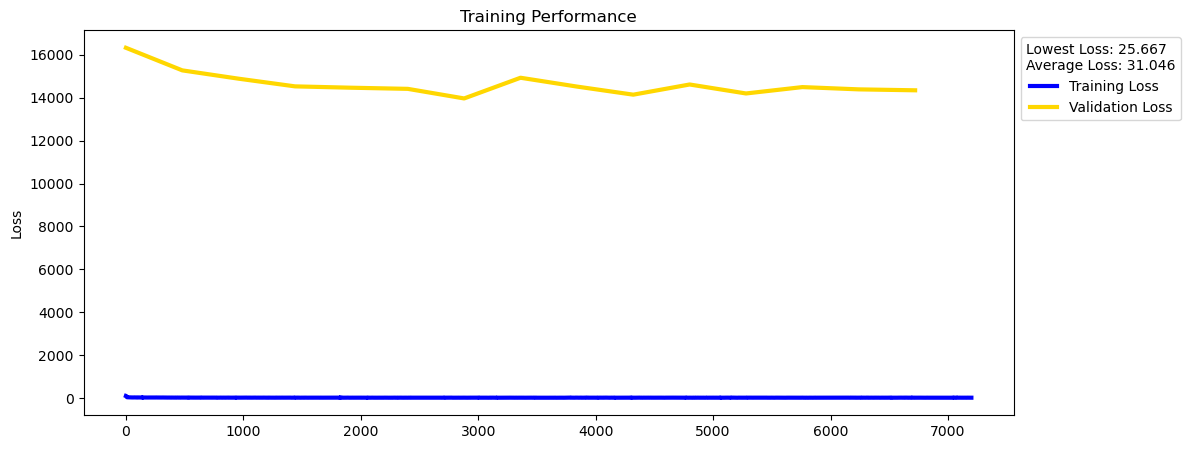

100%|██████████| 15/15 [01:51<00:00,  7.46s/it]


In [9]:
model = vae(
        input_dim=img_size, 
        hidden_dim=400, 
        num_layers=40, # y dim later (?)
        latent_dim=2, # x dim later (?)
        leak=0.01, drop=0.01,
        stochastic=False
    ).to(device)
nnet = net(model, train_loader, val_loader, test_loader, batch_size)

optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-6) #

nnet.train(optimizer=optimizer, epochs=15, x_dim=img_size, lsfn=loss_function)

### evaluate

Accuracy: 0.745


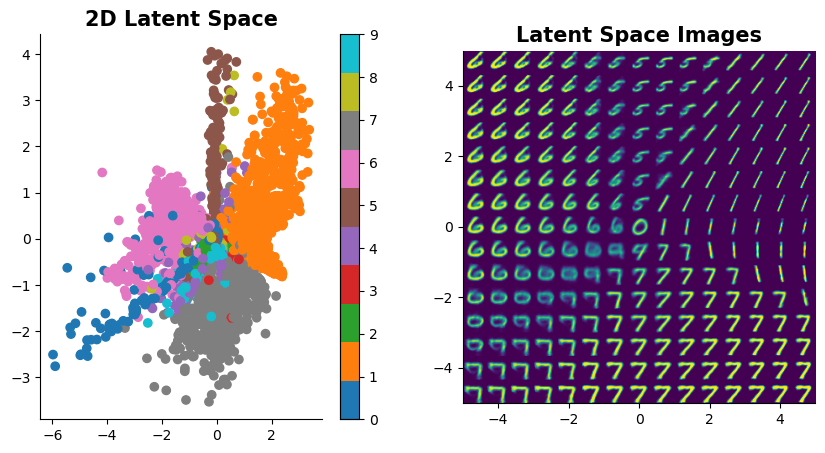

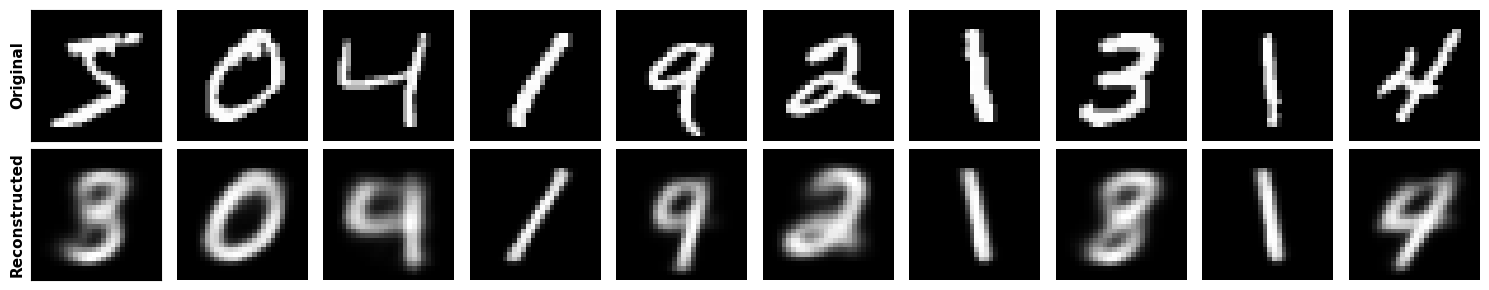

In [10]:
nnet.evaluate(test_loader)

plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.title("2D Latent Space", fontsize = 15, fontweight = 'bold')
nnet.plat(test_loader) 
sns.despine()

plt.subplot(1, 2, 2)
plt.title("Latent Space Images", fontsize = 15, fontweight = 'bold')
nnet.prec(test_dataset, n=15, rangex=(-5, 5), rangey=(-5, 5))
sns.despine()

nnet.pgen(test_loader, num_images=10)